# Выбор локации для скважины

Компании «ГлавРосГосНефть» необходимо определить, где бурить новую скважину.

Были предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 
Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяется значение признаков;
- Строится модель и оценивается объём запасов;
- Выбор месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

Все ключевые значения для расчётов сохраним в отдельных переменных

In [ ]:
#сохраним ключевые метрики в переменных
STATE = np.random.RandomState(12345) # рандом
PICK500 = 500 # по условию, для исследования берут 500 случайных скважин
BEST200 = 200 # 200 лучших скважин для разработки
PRICE = 450 # тыс. руб. дохода от 1000 баррелей сырья
BUDGET = 10000000 # тыс. руб. бюджет на разработку скважин
RISK_RATE = 0.025 # риск убытков

In [ ]:
try:
    region1 = pd.read_csv('/datasets/geo_data_0.csv')
    region2 = pd.read_csv('/datasets/geo_data_1.csv')
    region3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    region1 = pd.read_csv('/Users/knovikova/Downloads/geo_data_0.csv')
    region2 = pd.read_csv('/Users/knovikova/Downloads/geo_data_1.csv')
    region3 = pd.read_csv('/Users/knovikova/Downloads/geo_data_2.csv')

In [ ]:
import os

path1 = '/datasets/geo_data_0.csv'
path2 = '/Users/knovikova/Downloads/geo_data_0.csv'

if os.path.exists(path1):
    query_1 = pd.read_csv(path1)
elif os.path.exists(pth2):
    query_1 = pd.read_csv(path2)
else:
    print('Something is wrong')

In [ ]:
print("Геодата 1")
display(region1.head(10))
display(region1.info())
display(region1.describe())

print("Геодата 2")
display(region2.head(10))
display(region2.info())
display(region2.describe())

print("Геодата 3")
display(region3.head(10))
display(region3.info())
display(region3.describe())

Геодата 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Геодата 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Геодата 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Легенда**

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

В исходных данных нет пропусков. 
Все три датасета выглядят сопоставимыми - объем данных, их метрики средней/медианы, квантилей, а также минимальных и максимальных значений не отличаются настолько значительно, что мы бы не могли их анализировать и сравнивать друг с другом.

Объем нефти в регионах варьируется от 0 до 190 тыс. баррелей. Средний объем нефти в Регионах 1 и 3 примерно равны - 92.5 и 95 тыс. баррелей соответственно. У Региона 2 среднее значение запасов ниже - 69 быс. баррелей. При этом стандартное отклонение у всех регионов примерно одинаковое - 45, довольно большое значение, то есть разброс данных от выборочного среднего довольно велик.

Были выявлены дубликаты в id, но с разными показателями. Трудно сказать, почему на одной и той же скважине оказались разные данные, предлагаю удалить эти строки, к тому же их не очень много.

In [ ]:
#выявим дубликаты в id
print(region1['id'].duplicated().sum())
print(region2['id'].duplicated().sum())
print(region3['id'].duplicated().sum())
print(region1[region1['id'].duplicated(keep=False)])
print(region2[region2['id'].duplicated(keep=False)])
print(region3[region3['id'].duplicated(keep=False)])

#удалим дублирующие строки
region1 = region1.drop_duplicates(subset='id').reset_index(drop=True) 
region2 = region2.drop_duplicates(subset='id').reset_index(drop=True) 
region3 = region3.drop_duplicates(subset='id').reset_index(drop=True) 


10
4
4
          id        f0        f1         f2     product
931    HZww2  0.755284  0.368511   1.863211   30.681774
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
64022  74z30  0.741456  0.459229   5.153109  140.771492
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
89582  bsk9y  0.398908 -0.400253  10.1223

In [ ]:
#проверяем что строки удалены
display('Кол-во данных в Регионе 1:',len(region1))
display('Кол-во данных в Регионе 2:',len(region2))
display('Кол-во данных в Регионе 3:',len(region3))

'Кол-во данных в Регионе 1:'

99990

'Кол-во данных в Регионе 2:'

99996

'Кол-во данных в Регионе 3:'

99996

Удаляем столбец id, он не нужен для обучения, только для проверки возможных дубликатов данных.

In [ ]:
region1 = region1[['f0','f1','f2','product']]
region2 = region2[['f0','f1','f2','product']]
region3 = region3[['f0','f1','f2','product']]

Далее давайте посмотрим, есть ли сильный перекос в данных, чтобы понять, нужно ли будет масштабирование в дальнейшем.

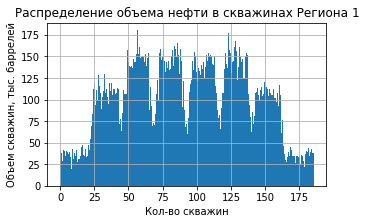

In [ ]:
region_hist1 = region1['product'].hist(bins=1000,figsize=(5, 3))
region_hist1.set_xlabel('Кол-во скважин')
region_hist1.set_ylabel('Объем скважин, тыс. баррелей')
region_hist1.set_title('Распределение объема нефти в скважинах Региона 1');

99984


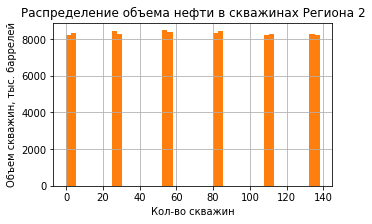

In [ ]:
region_hist2 = region2['product'].hist(bins=1000,figsize=(5, 3))
region_hist2.set_xlabel('Кол-во скважин')
region_hist2.set_ylabel('Объем скважин, тыс. баррелей')
region_hist2.set_title('Распределение объема нефти в скважинах Региона 2');

print(region2['product'].duplicated().sum())
region_hist2_1 = region2['product'].hist(bins=50,figsize=(5, 3))
region_hist2_1.set_xlabel('Кол-во скважин')
region_hist2_1.set_ylabel('Объем скважин, тыс. баррелей')
region_hist2_1.set_title('Распределение объема нефти в скважинах Региона 2');

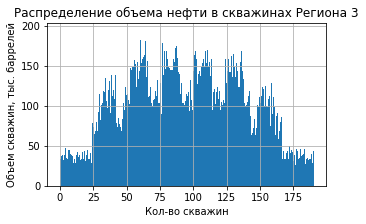

In [ ]:
region_hist3 = region3['product'].hist(bins=1000,figsize=(5, 3))
region_hist3.set_xlabel('Кол-во скважин')
region_hist3.set_ylabel('Объем скважин, тыс. баррелей')
region_hist3.set_title('Распределение объема нефти в скважинах Региона 3');

Объем нефти в регионах 1 и 3 распределены нормально, не думаю, что тут требуется масштабирование.

Интереснее со 2м регионом, там уникальных значений объема - 16, и при графике с 1000 корзин мы видим просто 4 тонкие палки, хотя при вызове функции info (в начале) этого не видно - данные выглядят сопоставими с 1 и 3 регионами. Если уменьшить число корзин, то видно, что данные распределены очень равномерно и строго в определенных диапазонах значений, нет выбросов.
Так что я думаю, 2й регион, несмотря на странное распределение данных, можно брать в обработку.

Итак, мы загрузили данные по трем регионам, верхнеуровнево проанализировали и сравнили их, удалили дубликаты по id скважин, а также избавились от ненужной для обучения информации в данных (id).
Далее мы построили графики распределения целевой метрики для каждого региона. Было выявлено, что Регионы 1 и 3 схожи основных метриках, таких как среднее, медиана и максимальный объем нефти, а также имеют схожее распределение целевого признака. Регион 2 отличается более низкими запасами нефти (показатели среднего и максимального значения) по сравнению с двумя другими регионами. Кроме того, его распределение отличается - данные целевого признака не распределены нормально, а сконцентрированы в четырех узких диапазонах значений.

Тем не менее, анализ показал, что отличия Региона 2 от других не являются критическими, данные все еще являются сопоставими с другими регионами.

## Обучение и проверка модели

Разделим данные по регионам на обучающие и валидационные выборки

In [ ]:
def split(data,size,random_rate):
    ft_train, ft_valid, tg_train, tg_valid = train_test_split(
    data.drop(['product'], axis=1),
    data['product'],
    test_size=size,
    random_state=random_rate)
    return ft_train, ft_valid, tg_train, tg_valid

ft_train_1, ft_valid_1, tg_train_1, tg_valid_1 = split(region1,0.25,STATE)
ft_train_2, ft_valid_2, tg_train_2, tg_valid_2 = split(region2,0.25,STATE)
ft_train_3, ft_valid_3, tg_train_3, tg_valid_3 = split(region3,0.25,STATE)

Обучим три модели с помощью линейной регресии.

In [ ]:
def linreg(ft_train,tg_train,ft_valid,tg_valid):
    model = LinearRegression()
    model.fit(ft_train,tg_train)
    pred_valid = model.predict(ft_valid)
    mean = round(pred_valid.mean(),3)
    rmse = round(mean_squared_error(tg_valid,pred_valid)**0.5,3)
    return model,mean,rmse,pred_valid
    
#для Региона 1   
model1, mean1, rmse1, pred_valid1 = linreg(ft_train_1,tg_train_1,ft_valid_1,tg_valid_1)
print("Среднее значение запасов Региона 1 =", mean1, "RMSE =",rmse1)

#для Региона 2
model2, mean2, rmse2, pred_valid2 = linreg(ft_train_2,tg_train_2,ft_valid_2,tg_valid_2)
print("Среднее значение запасов Региона 2 =", mean2, "RMSE =",rmse2)

#для Региона 3
model3, mean3, rmse3, pred_valid3 = linreg(ft_train_3,tg_train_3,ft_valid_3,tg_valid_3)
print("Среднее значение запасов Региона 3 =", mean3, "RMSE =",rmse3)


Среднее значение запасов Региона 1 = 92.789 RMSE = 37.854
Среднее значение запасов Региона 2 = 68.957 RMSE = 0.895
Среднее значение запасов Региона 3 = 95.079 RMSE = 40.042


В рамках данного блока мы разделили датасеты регионов на обучающие и валидационные выборки, а также создали три модели линейной регрессии для каждого региона и вывели среднее по прогнозным объемам нефти и среднеквадратичную ошибку. 

Предварительно мы видим, что по предсказаниям модели, средние запасы Региона 3 больше, чем у других регионов. Самые низкие у 2 Региона, зато они обладают наименьшим разбросом (помним почему).

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.


In [ ]:
cost_per_well = BUDGET/BEST200
print('Размер затрат на одну скважину:', cost_per_well)

oil_min = round(cost_per_well/PRICE,2)
print('Минимальный объем добычи нефти с одного месторождения:', oil_min)

Размер затрат на одну скважину: 50000.0
Минимальный объем добычи нефти с одного месторождения: 111.11


In [ ]:
#функция по расчету прибыли
def revenue(target, prediction, count):
    pred_sort = prediction.sort_values(ascending=False)
    best = target[pred_sort.index][:count]
    return PRICE * best.sum() - BUDGET

Минимальный объем превышает среднее предсказанное значение объема добычи всех трех регионов. Но это среднее по 25к скважинам, возможно, отобрав 200 лучших, мы увидим окупаемость.

## Расчёт прибыли и рисков 

Расчитаем прибыль для трех регионов.

Создадим функцию для расчета доверительного интервала 95%, средней прибыли 200 наилучших скважин региона, а также вероятность убытков

In [ ]:
def get_profit(tg_valid,pred_valid):
    revenue_list = [] #создаем список для сохранения значений выручки
    tg_valid = pd.Series(tg_valid).reset_index(drop=True) #превращаем таргет в объект Series иначе ничего не будет работать
    pred_valid = pd.Series(pred_valid) #same

    for i in range(1000):#проводим бустреп 1000 раз
        target_subsample = tg_valid.sample(n=PICK500, replace=True, random_state=STATE)#делаем подвыборку из 500 скважин (из 10к датасета) причем строки могут дулироваться см.пар-р replace
        probs_subsample = pred_valid[target_subsample.index] #тут мы берем 500 прогнозных значений, соответствующих подвыборки из таргетов строкой выше
        revenue_list.append(revenue(target_subsample,probs_subsample,BEST200))#применяем функцию по расчету прибыли, где выбираем 200 наиболее прибыльных скважин

    revenue_list = pd.Series(revenue_list) #снова делаем series 
    q1_05 = round(revenue_list.quantile(0.025),2) #ищем квантили
    q1_95 = round(revenue_list.quantile(0.975),2)

    mean = round(revenue_list.mean(),2) #среднюю выручку
    
    loss = [] #список для созранения предсказаний убытков
    for i in range(len(revenue_list)): 
        if revenue_list[i] < 0:
            loss.append(revenue_list[i])
    loss = pd.Series(loss)
    loss = round((len(loss)/len(revenue_list))*100,2) #ищем долю убыточных значений прибыли в общем числе предсказанной прибыли
    
    print('Средняя прибыль с 200 лучших скважин Региона:', mean)
    print(f'95% доверительный интервал от {q1_05} до {q1_95}')
    print(f'Риск убытка оценивается в {loss} %')
    
    return q1_05,q1_95,mean,loss

Применим функцию для тех регионов и рассмотрим полученные показатели.

In [ ]:
#Регион 1
print('Данные по Региону 1:')
q1_05_1,q1_95_1,mean1,loss1 = get_profit(tg_valid_1,pred_valid1)
print()

#Регион 2
print('Данные по Региону 2:')
q1_05_2,q1_95_2,mean2,loss2 = get_profit(tg_valid_2,pred_valid2)
print()

#Регион 3
print('Данные по Региону 3:')
q1_05_3,q1_95_3,mean3,loss3 = get_profit(tg_valid_3,pred_valid3)

Данные по Региону 1:
Средняя прибыль с 200 лучших скважин Региона: 420112.55
95% доверительный интервал от -107345.82 до 949083.86
Риск убытка оценивается в 5.9 %

Данные по Региону 2:
Средняя прибыль с 200 лучших скважин Региона: 496093.03
95% доверительный интервал от 59603.9 до 919393.74
Риск убытка оценивается в 0.7 %

Данные по Региону 3:
Средняя прибыль с 200 лучших скважин Региона: 474838.38
95% доверительный интервал от -80474.91 до 985944.26
Риск убытка оценивается в 4.3 %


В результате вычислений мы видим, что только Регион 2 с доверительным интервалом 95% покажет наибольшую среднюю прогнозируемую выручку. Кроме того, уровень риска у Региона 2 самый низкий, у Регионов 1 и 3 уровень риска превышает допустимое значение.


Таким образом, мы собрали исторические данные с трех регионов и построили модели, которые для каждого из регионов прогнозируется объем нефти в скважине по трем ключевым параметрам.

Далее мы смоделировали ситуацию, когда в рассматриваемом регионе берут 500 случайных скважин, прогнозируют по ним объем нефти, на основе полученных данных выбирают 200 лучших и строят прогноз прибыли по региону в целом с учетом риска убытков. Мы также применили boostrap, для многократного повторения отбора 500 скважин и отбора 200 лучших, чтобы снизить вероятность того, что мы переоценим/недооценим регион из-за неудачного сбора случайных скважин. Анализ показал, что Регион 2 обладает наибольшей средней прибылью и наименьшей величиной риска убытков.

**Вывод**: Наилучший регион для разработки месторождений - Регион 2.